Investigate the trend in data availability

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the data for each glacier, format into a single df
c=0
df_all = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>1: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'annual_observation_counts.csv')
    df_g = pd.read_csv(path_open,index_col=0)
    df_g['usable_freqency'] = df_g['usable_obs'] / df_g['total_obs']
    
    # add region info
    df_g['o1_region'] = str(o1region).zfill(2)
    df_g['o2_region'] = str(o2region).zfill(2)
    
    df_all.append(df_g)

# format into df
df_all = pd.concat(df_all)

print("All done!")


100 of 769 RGI2000-v7.0-G-13-24023
200 of 769 RGI2000-v7.0-G-14-01890
300 of 769 RGI2000-v7.0-G-14-19825
400 of 769 RGI2000-v7.0-G-14-30996
500 of 769 RGI2000-v7.0-G-15-01541
600 of 769 RGI2000-v7.0-G-15-05619
700 of 769 RGI2000-v7.0-G-15-09257
All done!


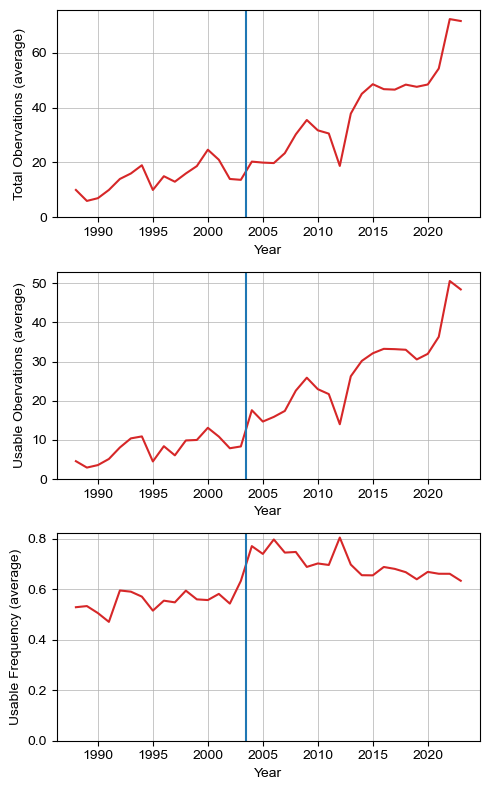

In [6]:
# plot median obs in each year
df_avg = df_all.groupby('year').median(numeric_only='True').reset_index()


# start figure
fig, axs = plt.subplots(3,1, figsize=(5,8))

axs[0].plot(df_avg['year'], df_avg['total_obs'],  c='tab:red')
axs[1].plot(df_avg['year'], df_avg['usable_obs'], c='tab:red')
axs[2].plot(df_avg['year'], df_avg['usable_freqency'], c='tab:red')

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Total Obervations (average)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Usable Obervations (average)")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Usable Frequency (average)")

for ax in axs:
    ax.grid(linewidth=0.5)
    ax.axvline(2003.5)
    ax.set_ylim(0,)
plt.tight_layout()

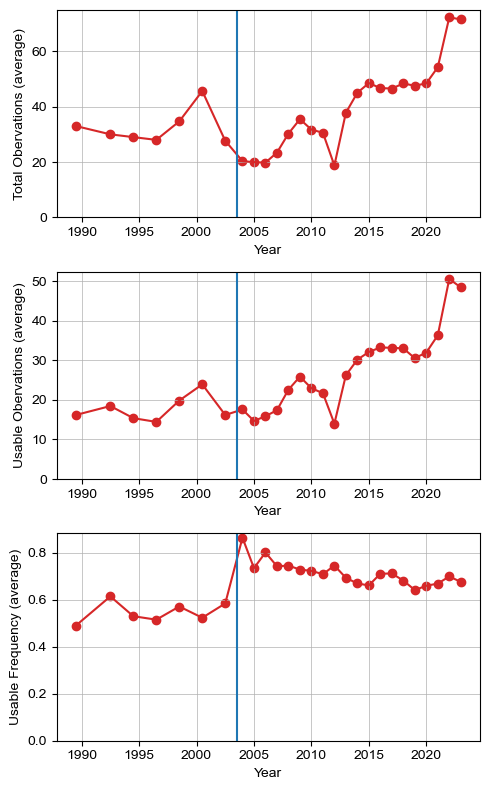

In [10]:
# bins = [[1988,1989,1990,1991,1992],
#         [1993,1994,1995],
#         [1996,1997,1998],
#         [1999,2000,2001],
#         [2002,2003] ] + [[i] for i in range(2004,2024)] 

bins = [[1988,1989,1990,1991],
        [1992,1993,1994],
        [1995,1996,1997],
        [1998,1999],
        [2000,2001],
        [2002,2003] ] + [[i] for i in range(2004,2024)] 

bins = [[1988,1989,1990,1991],
        [1992,1993],
        [1994,1995],
        [1996,1997],
        [1998,1999],
        [2000,2001],
        [2002,2003] ] + [[i] for i in range(2004,2024)] 

# bins = [[1988,1989,1990,1991,],
#         [1992,1993,1994],
#         [1995,1996,1997],
#         [1998,1999,2000],
#         [2001,2002,2003] ] + [[i] for i in range(2004,2024)] 

mids = [ (min(i)+max(i))/2 for i in bins ]


# df_avg = df_all[df_all['o1_region']=='15'].groupby('year').median(numeric_only='True').reset_index()
df_avg = df_all.groupby('year').median(numeric_only='True').reset_index()

binned_total = []
binned_usable = []
# recalculate everything for each year
for i in range(len(bins)):
    bins_i = bins[i]
    mids_i = mids[i]
    i_df = df_avg[df_avg['year'].isin(bins_i)]
    
    binned_total.append( i_df['total_obs'].sum() )
    binned_usable.append( i_df['usable_obs'].sum() )
    
binned_df = pd.DataFrame({'year':mids, 'total_obs':binned_total, 'usable_obs':binned_usable})
binned_df['usable_freqency'] = binned_df['usable_obs']/binned_df['total_obs']

# start figure
fig, axs = plt.subplots(3,1, figsize=(5,8))

axs[0].plot(binned_df['year'], binned_df['total_obs'],  c='tab:red')
axs[1].plot(binned_df['year'], binned_df['usable_obs'], c='tab:red')
axs[2].plot(binned_df['year'], binned_df['usable_freqency'], c='tab:red')
axs[0].scatter(binned_df['year'], binned_df['total_obs'],  c='tab:red')
axs[1].scatter(binned_df['year'], binned_df['usable_obs'], c='tab:red')
axs[2].scatter(binned_df['year'], binned_df['usable_freqency'], c='tab:red')

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Total Obervations (average)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Usable Obervations (average)")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Usable Frequency (average)")

for ax in axs:
    ax.grid(linewidth=0.5)
    ax.axvline(2003.5)
    ax.set_ylim(0,)
plt.tight_layout()

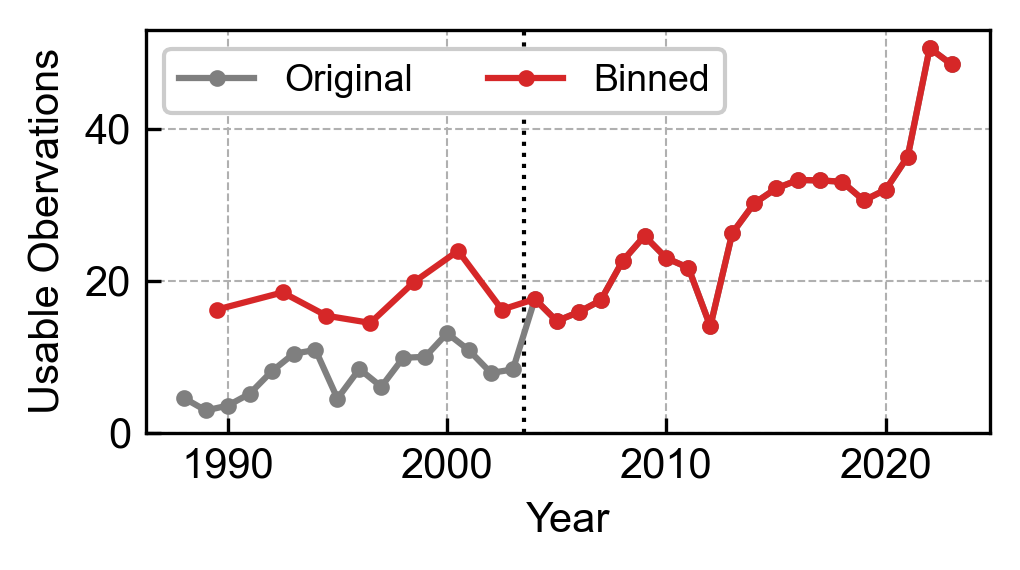

In [11]:
# figure showing with and without binning
# bins = [[1988,1989],
#         [1990,1991],
#         [1992,1993],
#         [1994,1995],
#         [1996,1997],
#         [1998,1999],
#         [2000,2001],
#         [2002,2003] ] + [[i] for i in range(2004,2024)] 

bins = [[1988,1989,1990,1991],
        [1992,1993],
        [1994,1995],
        [1996,1997],
        [1998,1999],
        [2000,2001],
        [2002,2003] ] + [[i] for i in range(2004,2024)] 

mids = [ (min(i)+max(i))/2 for i in bins ]


df_avg = df_all.groupby('year').median(numeric_only='True').reset_index()

binned_total = []
binned_usable = []

# recalculate everything for each year
for i in range(len(bins)):
    bins_i = bins[i]
    mids_i = mids[i]
    i_df = df_avg[df_avg['year'].isin(bins_i)]
    
    binned_total.append( i_df['total_obs'].sum() )
    binned_usable.append( i_df['usable_obs'].sum() )
    
binned_df = pd.DataFrame({'year':mids, 'total_obs':binned_total, 'usable_obs':binned_usable})
binned_df['usable_freqency'] = binned_df['usable_obs']/binned_df['total_obs']

# start figure
fig, axs = plt.subplots(figsize=(3.5,2), dpi=300)

axs.plot(df_avg['year'], df_avg['usable_obs'], c='tab:grey', marker='.', label='Original')
axs.plot(binned_df['year'], binned_df['usable_obs'],  c='tab:red', marker='.', label='Binned')


axs.set_xlabel("Year")
axs.set_ylabel("Usable Obervations")
axs.legend(framealpha=1, fontsize=9, ncols=2)
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs.axvline(2003.5, c='black', linestyle='dotted', zorder=1, linewidth=1)
axs.set_ylim(0,)
axs.tick_params(axis="both",direction="in")
plt.tight_layout()

In [18]:
print(df_avg[df_avg['year']<2003.5]['usable_obs'].median())
print(df_avg[df_avg['year']>2003.5]['usable_obs'].median())
print(binned_df[binned_df['year']<2003.5]['usable_obs'].median())

8.195929321189753
28.207933403074954
16.19452422365924
